# The Capture24 dataset

The Capture-24 dataset consists of wrist-worn accelerometer measurements collected from about 150 participants that wore the device for 24 hours.

The two main files we will work with are `X_raw.dat` and `capture24.npz`. The
latter is a bundle of numpy arrays as shown below.

We start by setting up some modules and functions:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import manifold
import utils  # contains helper functions for this workshop -- check utils.py

# For reproducibility
np.random.seed(42)

# A useful plotting function
def my_scatter_plot(X, y):
    fig, ax = plt.subplots()
    for i in range(utils.NUM_CLASSES):
        ax.scatter(X[y==i, 0], X[y==i, 1],
            c=utils.COLORS[i], label=utils.CLASSES[i], alpha=0.25, s=10)
    fig.legend()
    return fig, ax

 Load the dataset files: 

In [3]:
# data = np.load('capture24.npz', allow_pickle=True)
data = np.load('/tmp/capture24_small.npz', allow_pickle=True)
print("Data contents:", data.files)
X_feats, y, pid, time, annotation = data['X_feats'], data['y'], data['pid'], data['time'], data['annotation']
print('X_feats shape:', X_feats.shape)
print('y shape:', y.shape)
print('pid shape:', pid.shape)
print('time shape:', time.shape)
print('annotation shape:', annotation.shape)
# X_raw = np.memmap('X_raw.dat', dtype='float32', mode='r').reshape(-1,3,3000)
X_raw = np.load('/tmp/X_raw_small.npy')
print('X_raw shape:', X_raw.shape)

Data contents: ['X_feats', 'y', 'pid', 'time', 'annotation']
X_feats shape: (11016, 125)
y shape: (11016,)
pid shape: (11016,)
time shape: (11016,)
annotation shape: (11016,)
X_raw shape: (11016, 3, 3000)


*Description of the numpy arrays*

- `X_raw.dat` numpy array of shape `(N,3,3000)` where each row corresponds to 30 seconds of *raw* tri-axial acceleration measurement (at 100Hz).

- `X_feats.npy` numpy array of shape `(N,125)` where each row corresponds to *hand-crafted features* for 30 seconds measurement.

- `y.npy` numpy array of shape `(N,)` indicating the activity (0: sleep, 1: sedentary, 2: tasks-light, 3: walking, 4: moderate) performed during the 30 seconds measurement.

- `time.npy` numpy array of shape `(N,)` indicating the start time of the corresponding measurement.

- `pid.npy` numpy array of shape `(N,)` indicating the participant ID for the corresponding measurement.

- `annotation.npy` numpy arrayof shape `(N,)` containing fine-grained activity annotations for the corresponding measurement.

Arrays `X_feats`, `y.npy`, `time.npy`, `pid.npy` and `annotation.npy` are stored in a single `capture24.npz` file, while `X_raw.dat` is stored separately as a numpy `memmap` due to its large size (~14GB).

**Note:** The provided arrays `X_feats`, `X_raw`, `y`, etc. are so that measurements of a same participant are contiguous and continuous time intervals correspond to continuous rows, however interrupts (time gaps) in the measurements may exist.
Time discontinuities will also of course occur at the edges between participants.

# Visualization
Visualizing the dataset is an important part of data science. This can
provide useful insights about the problem at hand.

Let's visualize one instance of each activity type:

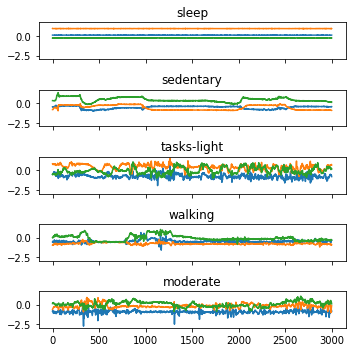

In [4]:
fig, axs = plt.subplots(5, sharex=True, sharey=True, figsize=(5,5))
for i in range(utils.NUM_CLASSES):
    axs[i].plot(X_raw[y == i][0].T)
    axs[i].set_title(utils.CLASSES[i])
fig.tight_layout()
fig.show()
# fig.savefig('activities.png', bbox_inches='tight')

After visualizing individual instances, the next step is to visualize
our dataset as a whole to have a grasp of the data distribution. A
standard visualization approach is to scatter-plot the two principal
components of our dataset.
For performance, in the following we perform visualizations on
smaller subsets of our data since our data is rather big:

In [5]:
# grab first 10k
X_raw = X_raw[:10000]
X_feats = X_feats[:10000]
y = y[:10000]
pid = pid[:10000]
time = time[:10000]
annotation = annotation[:10000]

 Perform PCA on our raw dataset: 

Plotting first two PCA components...


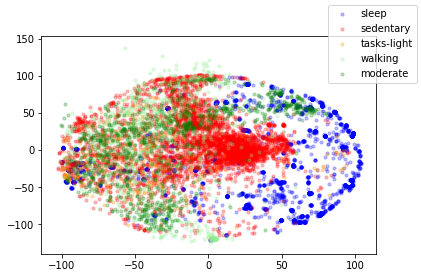

In [6]:
print("Plotting first two PCA components...")
scaler = preprocessing.StandardScaler()  # PCA requires normalized data
X_raw_scaled = scaler.fit_transform(X_raw.reshape(X_raw.shape[0],-1))
pca = decomposition.PCA(n_components=2)  # two components
X_pca = pca.fit_transform(X_raw_scaled)
fig, ax = my_scatter_plot(X_pca, y)
fig.show()
# fig.savefig('pca_plot.png', bbox_inches='tight')

The PCA plot is already very informative. What if we want to
visualize more components? A popular high-dimensional data visualization tool
is _t-distributed stochastic neighbor embedding_ (t-SNE). We next use t-SNE to
visualize 128 principal components of our raw dataset:

*Note this next step will take a few minutes to run*

Plotting t-SNE on PCA components...


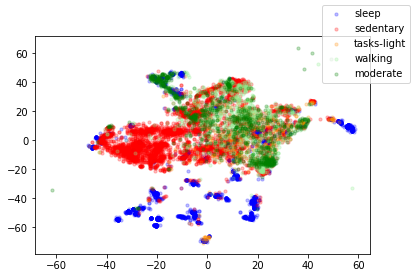

In [7]:
print("Plotting t-SNE on PCA components...")
pca = decomposition.PCA(n_components=128)  # 128 components
X_pca = pca.fit_transform(X_raw_scaled)
tsne = manifold.TSNE(n_components=2,  # project down to 2 components
    init='random', random_state=42, perplexity=100)
X_tsne_pca = tsne.fit_transform(X_pca)
fig, ax = my_scatter_plot(X_tsne_pca, y)
fig.show()
# fig.savefig('tsne_on_pca_plot.png', bbox_inches='tight')

Finally, let's perform a t-SNE visualization this time on the
hand-crafted features `X_feats`:

*Note this next step will take a few minutes to run*

In [ ]:
print("Plotting t-SNE on hand-crafted features...")
tsne = manifold.TSNE(n_components=2,
    init='random', random_state=42, perplexity=100)
X_tsne_feats = tsne.fit_transform(X_feats)
fig, ax = my_scatter_plot(X_tsne_feats, y)
fig.show()
# fig.savefig('tsne_on_feats_plot.png', bbox_inches='tight')

Our preliminary plots seem to suggest that classifying "sleep" and
"sedentary" activities may be easy while classifying "tasks-light", "walking"
and "moderate" activities may be more challenging.

*To try:*

- Tune the `perplexity` parameter of t-SNE to see how it affects the plots.
- Our dataset is highly unbalanced:

In [ ]:
print(np.unique(y, return_counts=True))

As seen, there is barely any "tasks-light" activities (category 2). To aid the
visualization, try balancing the activities to be scatter-plotted.